In [1]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#load dynamics from log file
def load_from_file(file_name):
    v = numpy.loadtxt(file_name)

    u = numpy.array(v[:, 1:3])
    x = numpy.array(v[:, 3:5])

    dt= v[:, -1].mean()*0.001
    t = numpy.arange(x.shape[0])*dt
    
    return u, x, t, dt


def state_augmentation(x, wheel_diameter = 34.0*0.001, wheel_brace = 80.0*0.001):

    n_steps = x.shape[0]
    
    right_position= x[:, 1] 
    left_position = x[:, 0]

    distance = 0.25*(right_position + left_position)*wheel_diameter
    angle    = 0.5*(right_position - left_position)*wheel_diameter / wheel_brace
    
    #zero initial conditions
    distance = distance - distance[0]
    angle    = angle - angle[0]

    x_aug = numpy.zeros((n_steps, 2))
    x_aug[:, 0] = distance
    x_aug[:, 1] = angle

    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1):

    plt.clf()
    
    fig, axs = plt.subplots(4, 1, figsize=(8, 2*5))


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control left")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control right")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [m]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1], color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1], color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [rad]")
    axs[3].grid()

    

    #fig.legend()


def matrix_to_c(name, x):

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [2]:
#obtain response
u_result, x_ref, t_result, dt = load_from_file("./data/run_4.log")
x_ref = state_augmentation(x_ref)


#identification
a_est, b_est = LibsControl.recursive_ls_identification(u_result, x_ref)
    
c_est = numpy.eye(a_est.shape[0])


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")



n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]



mat_a = 
 [[1.00019705e+00 2.33553663e-06]
 [2.03659903e-04 1.00037850e+00]] 


mat_b = 
 [[ 3.49239975e-05  3.50567229e-05]
 [-8.66463922e-04  8.57604248e-04]] 


mat_c = 
 [[1. 0.]
 [0. 1.]] 




<Figure size 640x480 with 0 Axes>

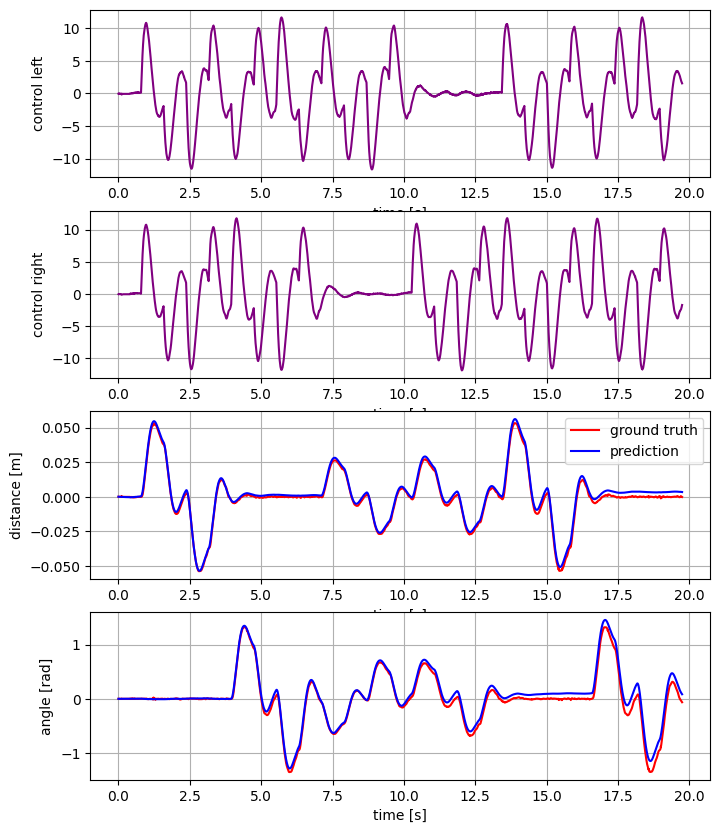

In [3]:
#model verification
#set same inputs and initial conditions

ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, None)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)

#plot results
plot_results(t_result, u_result, x_ref, x_hat_result, 0, 5000)


In [4]:
#controller synthetis

#create loss weighting matrices (diagonal)
q = numpy.diag([ 1500.0, 1.0] )
r = numpy.diag( [1.0, 1.0]) 

#1400rpm max
antiwindup = (1400/60.0)*2.0*numpy.pi

#solve LQR controller
lqr = LibsControl.LQRDiscrete(a_est, b_est, q, r, antiwindup)

print("controller")
print("k  = \n", lqr.k, "\n")
print("ki = \n", lqr.ki, "\n")
print("\n\n")



controller
k  = 
 [[911.41934001 -29.63950846]
 [919.92225609  29.53955154]] 

ki = 
 [[28.14886223 -0.72751152]
 [28.35068432  0.72231699]] 






<Figure size 640x480 with 0 Axes>

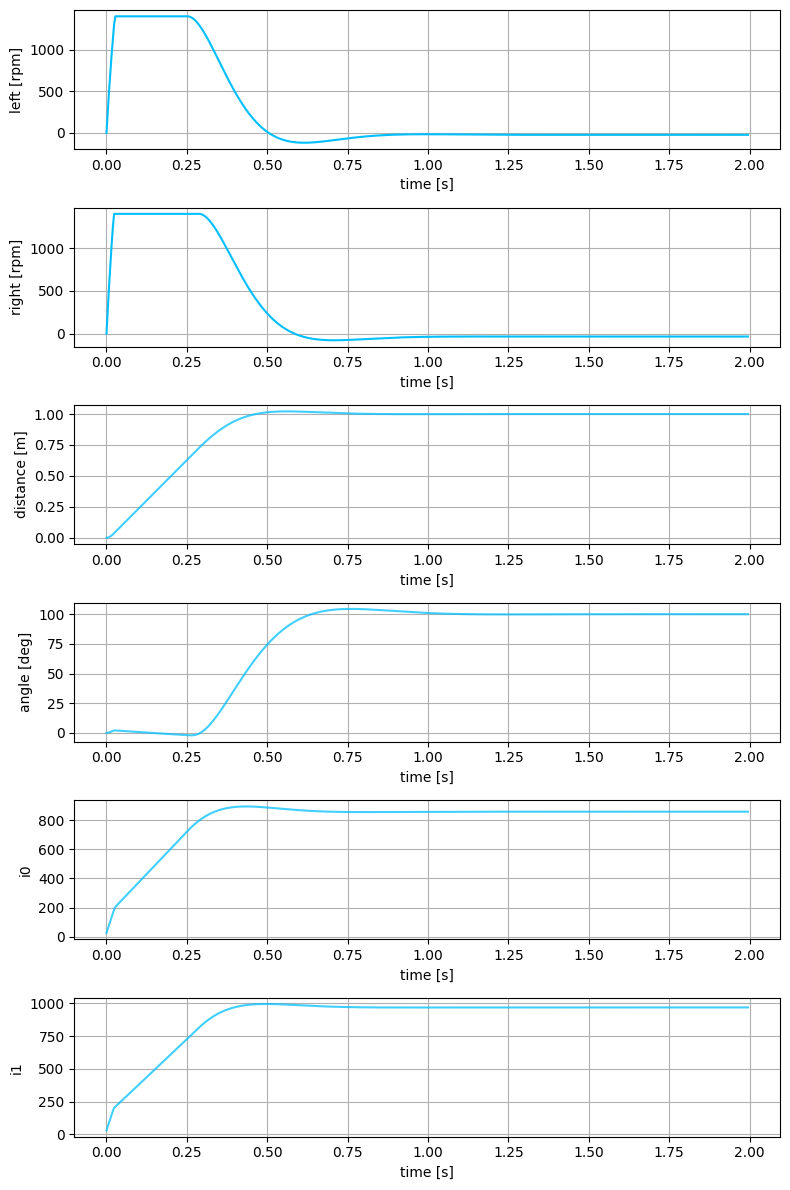

In [5]:
#process simulation

n_max = int(2.0/dt)

#required output, 1 meter, 100degrees
xr = numpy.array([[1.0, 100.0*numpy.pi/180.0]]).T

#initial error integral
integral_action = numpy.zeros((b_est.shape[1], 1))

#result log
t_result = [] 
u_result = []
x_result = []
int_result = []


#plant state
x     = numpy.zeros((a_est.shape[0], 1))

for n in range(n_max):

    #compute controller output
    u, integral_action = lqr.forward(xr, x, integral_action)
    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    int_result.append(integral_action[:, 0].copy())
    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)
x_result = numpy.array(x_result)

int_result = numpy.array(int_result)


u_result*= 60.0*1.0/(2.0*numpy.pi)

#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqg_discrete_output.png", u_labels = ["left [rpm]", "right [rpm]"], x_labels = ["distance [m]", "angle [deg]"])




In [6]:
#print c-like arrays
print(matrix_to_c("k", lqr.k))
print(matrix_to_c("ki", lqr.ki))


float k[] = {
		911.4193, -29.63951, 
		919.92224, 29.53955 };

float ki[] = {
		28.148863, -0.7275115, 
		28.350685, 0.722317 };

